# Matrix factorization for movielens dataset tutorial

In this notebook, we will guide you through the process of building a vanialla matrix factorization model for the movielens dataset.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product
from cf_baseline.algos import VanillaMF
from torch.utils.data import Dataset, DataLoader
from cf_baseline.common import get_device
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/collaborative-filtering-baseline-VTPPmAaj-py3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Getting data

We'll use the MovieLens 100k dataset, which contains 100,000 ratings from 1000 users on 1700 movies. The ratings are on a scale from 1 to 5, and have been collected over several years. The dataset is available from GroupLens, a research lab at the University of Minnesota. The dataset is also available on Kaggle.

Before executing the code in this notebook, you'll need to download the dataset and unzip it. You can do this by running the following commands:

```zsh
$ python scripts/download_movielens_dataset.py
```

In [2]:
df = pd.read_csv("../dataset/unzipped/ml-latest-small/ratings.csv")
df.head()
df.shape

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


(100836, 4)

Let's see how many users and items are in the dataset.

In [3]:
n_users = df.userId.nunique()
n_items = df.movieId.nunique()

print(
    "Number of unique users: ", n_users, "\n", 
    "Number of unique items: ", n_items,
    sep=''
)

Number of unique users: 610
Number of unique items: 9724


For simplicity, we'll only use the first 10 users and 10 items.

In [4]:
sample_users = list(df.userId.value_counts().head(10).index)  # top 10 users
sample_items = list(df.movieId.value_counts().head(10).index)  # top 10 items

In [5]:
sample_df = df[df.userId.isin(sample_users) & df.movieId.isin(sample_items)]
sample_df.head()
sample_df.shape

,userId,movieId,rating,timestamp
10386,68,110,2.5,1158531496
10412,68,260,5.0,1158531191
10419,68,296,2.0,1180916156
10423,68,318,3.0,1158531293
10431,68,356,3.5,1158531181


(95, 4)

In [6]:
pd.pivot_table(sample_df, values='rating', index='userId', columns='movieId')

movieId,110,260,296,318,356,480,527,589,593,2571
userId,,,,,,,,,,
68,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,4.5
274,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.0
288,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,3.0
380,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,4.5
414,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0
448,NaN,5.0,5.0,NaN,3.0,3.0,NaN,3.0,5.0,2.0
474,3.0,4.0,4.0,5.0,3.0,4.5,5.0,4.0,4.5,4.5
599,3.5,5.0,5.0,4.0,3.5,4.0,NaN,4.5,3.0,5.0
606,3.5,4.5,5.0,3.5,4.0,2.5,5.0,3.5,4.5,5.0


## Modeling

In [7]:
device = get_device()
seed = 100

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

### Preparing data

Before we start, let's encode the user and item IDs into sequential integers for convenience.

In [8]:
user2idx = {user: idx for idx, user in enumerate(sample_df.userId.unique())}
idx2user = {idx: user for user, idx in user2idx.items()}

item2idx = {item: idx for idx, item in enumerate(sample_df.movieId.unique())}
idx2item = {idx: item for item, idx in item2idx.items()}

In [9]:
encoded_df = sample_df.copy()

encoded_df["userId"] = encoded_df["userId"].map(user2idx)
encoded_df["movieId"] = encoded_df["movieId"].map(item2idx)

pd.pivot_table(encoded_df, values='rating', index='userId', columns='movieId')

movieId,0,1,2,3,4,5,6,7,8,9
userId,,,,,,,,,,
0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,4.5
1,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.0
2,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,3.0
3,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,4.5
4,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0
5,NaN,5.0,5.0,NaN,3.0,3.0,NaN,3.0,5.0,2.0
6,3.0,4.0,4.0,5.0,3.0,4.5,5.0,4.0,4.5,4.5
7,3.5,5.0,5.0,4.0,3.5,4.0,NaN,4.5,3.0,5.0
8,3.5,4.5,5.0,3.5,4.0,2.5,5.0,3.5,4.5,5.0


Now, data looks good to go. Let's start modeling.

### Hyperparameters

In [10]:
N_EPOCH = 500
BATCH_SIZE = 95
LEARNING_RATE = 3e-3
LATENT_DIM = 7

### Creating a dataloader

In [11]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        user_id = self.df.iloc[idx].userId
        item_id = self.df.iloc[idx].movieId
        rating = self.df.iloc[idx].rating
        
        return user_id.astype("int"), item_id.astype("int"), rating.astype("float32")

In [12]:
# Train test split
train_df = encoded_df.copy().sample(frac=0.8, random_state=seed)
test_df = encoded_df.copy().drop(train_df.index)

# Create dataloader
train_loader = DataLoader(
    CustomDataset(train_df.copy()),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_loader = DataLoader(
    CustomDataset(test_df.copy()),
    batch_size=test_df.shape[0],
)

In [13]:
# Sample batch output
iter(train_loader).next()

[tensor([5, 6, 8, 9, 5, 3, 9, 8, 4, 7, 1, 8, 0, 6, 0, 7, 4, 3, 2, 3, 4, 4, 7, 7,
         5, 3, 7, 3, 9, 9, 1, 6, 8, 0, 7, 6, 0, 0, 4, 2, 0, 8, 6, 1, 4, 2, 4, 2,
         2, 1, 8, 9, 9, 0, 4, 4, 6, 2, 6, 8, 1, 8, 9, 2, 6, 5, 3, 9, 3, 8, 5, 2,
         1, 3, 2, 7]),
 tensor([8, 8, 2, 9, 9, 0, 3, 3, 4, 7, 2, 5, 7, 6, 0, 2, 8, 8, 1, 9, 6, 2, 9, 5,
         4, 2, 4, 7, 5, 1, 7, 3, 1, 3, 8, 9, 5, 1, 0, 7, 4, 8, 7, 1, 7, 9, 1, 6,
         2, 9, 9, 7, 6, 6, 5, 3, 0, 8, 5, 7, 3, 6, 0, 0, 1, 1, 1, 4, 3, 0, 2, 3,
         8, 5, 5, 3]),
 tensor([5.0000, 4.5000, 5.0000, 5.0000, 2.0000, 4.0000, 3.0000, 3.5000, 5.0000,
         4.5000, 5.0000, 2.5000, 3.5000, 5.0000, 2.5000, 5.0000, 4.0000, 5.0000,
         5.0000, 4.5000, 4.0000, 5.0000, 5.0000, 4.0000, 3.0000, 5.0000, 3.5000,
         5.0000, 5.0000, 5.0000, 4.5000, 5.0000, 4.5000, 3.0000, 3.0000, 4.5000,
         3.5000, 5.0000, 5.0000, 4.0000, 3.5000, 4.5000, 4.0000, 3.0000, 5.0000,
         3.0000, 5.0000, 5.0000, 5.0000, 4.0000, 5.0000, 5.0000

### Defining the model

In [14]:
model = VanillaMF(
    n_users=10, 
    n_items=10,
    latent_dim=LATENT_DIM
).to(device)

print(model)

VanillaMF(
  (user_embeddings): Embedding(10, 7)
  (item_embeddings): Embedding(10, 7)
)


This model is a simple matrix factorization model. We'll use the `nn.Embedding` layer to learn the latent factors for users and items.

Where loss function is the mean squared error, and optimizer is Adam.

```python
def loss_fn(self, preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """
    Simple MSE loss as the loss function for the model.
    
    Args:
        preds: predicted scores
        targets: ground truth scores
        
    Returns:
        MSE of the predictions and the ground truth
    """
    
    return ((preds - targets) ** 2).mean()
```

In [15]:
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Training loop

In [16]:
loss_hist = []
eval_loss_hist = []

for epoch in range(0, N_EPOCH):
    for i, (user_ids, item_ids, ratings) in enumerate(train_loader):
        user_ids = user_ids.to(device)
        item_ids = item_ids.to(device)
        ratings = ratings.to(device)
        
        # training
        _ = model.train()
        opt.zero_grad()
        
        pred_scores = model(user_ids, item_ids)
        loss = VanillaMF.loss_fn(pred_scores, ratings)
        
        loss.backward()
        opt.step()
        
        # evaluation
        _ = model.eval()
        
        with torch.no_grad():
            eval_loss = 0
            for j, (user_ids, item_ids, ratings) in enumerate(test_loader):
                user_ids = user_ids.to(device)
                item_ids = item_ids.to(device)
                ratings = ratings.to(device)
                
                pred_scores = model(user_ids, item_ids)
                eval_loss += VanillaMF.loss_fn(pred_scores, ratings)
                
            eval_loss /= len(test_loader)
        
        loss_hist.append(loss.item())
        eval_loss_hist.append(eval_loss.item())
        
    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Iter: {i}, Loss: {loss.item():.4f}, Eval Loss: {eval_loss.item():.4f}")

Epoch: 0, Iter: 0, Loss: 24.8049, Eval Loss: 24.7765
Epoch: 20, Iter: 0, Loss: 22.0311, Eval Loss: 23.8884
Epoch: 40, Iter: 0, Loss: 19.5266, Eval Loss: 23.0828
Epoch: 60, Iter: 0, Loss: 17.2088, Eval Loss: 22.2253
Epoch: 80, Iter: 0, Loss: 15.0367, Eval Loss: 21.2778
Epoch: 100, Iter: 0, Loss: 12.9978, Eval Loss: 20.2324
Epoch: 120, Iter: 0, Loss: 11.0990, Eval Loss: 19.0841
Epoch: 140, Iter: 0, Loss: 9.3577, Eval Loss: 17.8468
Epoch: 160, Iter: 0, Loss: 7.7929, Eval Loss: 16.5516
Epoch: 180, Iter: 0, Loss: 6.4174, Eval Loss: 15.2413
Epoch: 200, Iter: 0, Loss: 5.2350, Eval Loss: 13.9666
Epoch: 220, Iter: 0, Loss: 4.2392, Eval Loss: 12.7763
Epoch: 240, Iter: 0, Loss: 3.4159, Eval Loss: 11.7070
Epoch: 260, Iter: 0, Loss: 2.7463, Eval Loss: 10.7787
Epoch: 280, Iter: 0, Loss: 2.2090, Eval Loss: 9.9964
Epoch: 300, Iter: 0, Loss: 1.7828, Eval Loss: 9.3536
Epoch: 320, Iter: 0, Loss: 1.4478, Eval Loss: 8.8364
Epoch: 340, Iter: 0, Loss: 1.1861, Eval Loss: 8.4270
Epoch: 360, Iter: 0, Loss: 0.98

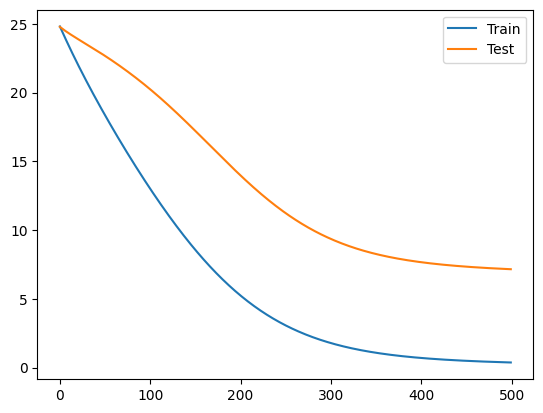

In [17]:
_ = plt.plot(loss_hist, label="Train")
_ = plt.plot(eval_loss_hist, label="Test")
_ = plt.legend()

### Predicting scores

In [18]:
user_item_pair = list(product(range(10), range(10)))
user_item_pair = np.array(user_item_pair)


In [19]:
_ = model.eval()

# Predict scores for all user-item pairs
user_ids = torch.IntTensor(user_item_pair[:, 0].copy()).to(device)
item_ids = torch.IntTensor(user_item_pair[:, 1].copy()).to(device)

pred = model(
    user_ids,
    item_ids
)

user_item_score = pd.DataFrame(user_item_pair.copy(), columns=["userId", "movieId"])
user_item_score["pred"] = pred.cpu().detach().numpy()

In [20]:
# Result from the model
pd.pivot_table(user_item_score, values='pred', index='userId', columns='movieId').round(1)

movieId,0,1,2,3,4,5,6,7,8,9
userId,,,,,,,,,,
0,2.9,5.2,2.2,3.1,3.6,2.9,3.3,3.4,4.5,3.3
1,2.9,2.3,6.0,2.8,-1.3,4.0,-0.7,3.1,3.9,5.0
2,4.0,5.8,4.3,4.6,4.1,3.3,5.1,3.8,3.9,4.0
3,4.3,5.2,4.8,3.0,3.4,4.9,-1.5,5.8,5.1,3.8
4,4.9,4.3,4.5,4.7,4.9,4.7,4.2,5.8,3.6,3.8
5,-5.3,4.9,5.1,-0.2,3.0,3.3,-5.4,9.8,5.1,1.9
6,3.8,4.6,3.2,4.0,3.3,3.3,4.8,3.3,4.4,4.2
7,2.6,1.1,5.7,3.7,3.4,3.6,5.9,4.8,3.7,3.9
8,3.2,4.3,4.8,4.2,2.4,3.2,5.3,3.1,4.6,4.8


In [21]:
# Actual result
pd.pivot_table(encoded_df, values='rating', index='userId', columns='movieId')

movieId,0,1,2,3,4,5,6,7,8,9
userId,,,,,,,,,,
0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,4.5
1,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.0
2,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,3.0
3,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,4.5
4,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0
5,NaN,5.0,5.0,NaN,3.0,3.0,NaN,3.0,5.0,2.0
6,3.0,4.0,4.0,5.0,3.0,4.5,5.0,4.0,4.5,4.5
7,3.5,5.0,5.0,4.0,3.5,4.0,NaN,4.5,3.0,5.0
8,3.5,4.5,5.0,3.5,4.0,2.5,5.0,3.5,4.5,5.0
